# Load the Packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Setting up Shapefiles

[Shapefiles](https://en.wikipedia.org/wiki/Shapefile) are a collection of file formats that are commonly used for working with geospatial data.

Shapefiles can take the form of various *geometries*: points, lines, polylines, and polygons. We can use these geometries as containers onto which we can attach attributes and features the same way we would add columns to a table.

### Coordinate Reference System (CRS)

When working with geospatial data, we need to make sure that all of our data uses the same [coordinate reference system (crs)](https://en.wikipedia.org/wiki/Spatial_reference_system). CRS varies from region to region, but the most commonly used one is [WGS-84](https://epsg.io/4326) (latitude/longitude).

### Census Tracts

Census tracts are the second smallest geographical unit used by the Census Bureau. Each tract has a 6-digit unique identifier that can be extended to include information specifying the county and state. In NYC, boroughs are coterminous with counties, meaning they have identical geographic boundaries. When working with NYC census data, census tracts are uniquely identified by a 6-digit code: the first digit represents the borough/county, followed by six digits for the tract.

**NOTE:** It's important that you use the 7-digit code (usually called `boro_ct2010` or something similar) and not the 6-digit `ct2010` code. Census tracts in different counties can have overlapping IDs!

In [2]:
#load the shapefile located in 'data/nyc_tracts/ct2010.shp'
tracts = gpd.GeoDataFrame.from_file('data/nyc_tracts/ct2010.shp')

#set the crs to 'epsg:4326'
tracts.crs = {'init': 'epsg:4326'}

#rename the census tract id column 'boro_ct201' to  'tract' for easier merging
tracts = tracts.rename(columns = {'boro_ct201': 'tract'})

#convert to a string for merging purposes
tracts['tract'] = tracts.tract.astype(str)

tracts.head()

,boro_code,tract,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


# Merging Population Data onto Shapefiles

The [United States Census Bureau](https://www.census.gov/data.html) makes all of its data public. You can either download csvs from the [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml) or use the [Census API](https://www.census.gov/data/developers/data-sets.html).

NYC Planning also has a nice [NYC Population FactFinder](https://popfactfinder.planning.nyc.gov/#12.25/40.724/-73.9868) tool which makes it easier to interact with NYC census data.

There are also several [python packages](https://github.com/datamade/census) that make working with census data much easier.

*Pulling census data is not the easiest process, so I'm giving you a nice clean dataset of population data taken from the 2010 census.*

**File location:** "data/pop2010.csv"

In [3]:
pop = pd.read_csv('data/pop2010.csv', dtype={'tract': str, 'pop': int})
pop.head()

,tract,pop
0,2000100,11091
1,2000200,4334
2,2000400,5503
3,2001600,5643
4,2001900,1917


**IMPORTANT:** We're going to perform a *left join* by merging the population data onto the census tract shapefiles. This is necessary when working with geopandas because if done the other way around, the GeoDataFrame format will break and we won't be able to map our data.

[Here's an article](https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html) that does a pretty good job of explaining joins in python if you want to learn more.

In [4]:
#merge the 'pop' dataset onto tracts
tracts = tracts.merge(pop, how = 'left', on = 'tract')
tracts.head()

,boro_code,tract,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,pop
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...,2112
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...,7316
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...,1992
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,230
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,966


# Plotting

Now that we have our population data attached to our shapefiles, we can already go ahead and do some plotting. Geopandas plotting features are built on top of matplotlib, so we can use it's syntax. Whether or not that is a good thing is up to you to decide.

Matplotlib has a decent selection of [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) that you can choose from.

It's possible to [create your own custom colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html), but that takes time and goes a bit beyond the scope of this workshop.

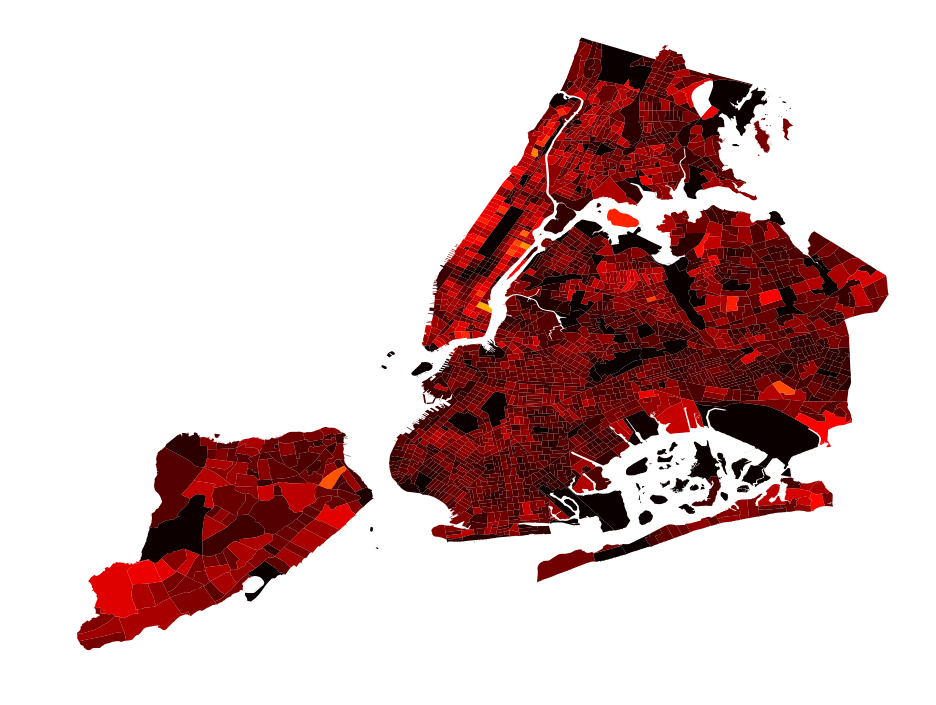

In [5]:
#set-up the canvas
fig, ax = plt.subplots(figsize = (16,16))

#plot a choropleth map using data from the 'pop' column of the 'tracts' dataset
#you can specify what colormap you want to use with the 'cmap' parameter
#sometimes you might want to reverse the direction of colormap by adding '_r' to the end of the colormap's name
tracts.plot(ax = ax, column = 'pop', cmap = 'hot')

#we can also turn off the axes to make things look cleaner
ax.axis('off')

#this last function displays your map
plt.show()

# Noise Complaints

Now that we have our census tracts and population data set up, let's move on to our 311 data. The [311 Service Requests](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) dataset is one of the most popular datasets on the NYC Open Data Portal.

For those unfamiliar with [311](https://www1.nyc.gov/311/our-mission.page), it's a service offered by the city government which allows New Yorkers to report non-emergencies like potholes or noise complaints.

This dataset has been filtered for commercial noise complaints placed between the hours of 7:00pm to 5:00am.

In [6]:
noise = pd.read_csv('data/noise311.csv')
noise.head()

,datetime,description,location_type,address,street,lat,lon
0,1/2/2013 20:49,Loud Music/Party,Store/Commercial,225 CHAUNCEY STREET,CHAUNCEY STREET,40.680803,-73.926067
1,1/3/2013 23:46,Loud Music/Party,Club/Bar/Restaurant,64 EAST 1 STREET,EAST 1 STREET,40.723582,-73.989162
2,1/3/2013 22:39,Loud Music/Party,Club/Bar/Restaurant,1233 FLATBUSH AVENUE,FLATBUSH AVENUE,40.640182,-73.955306
3,1/3/2013 23:22,Loud Music/Party,Club/Bar/Restaurant,119 ST MARKS PLACE,ST MARKS PLACE,40.727267,-73.984497
4,1/4/2013 0:53,Loud Music/Party,Club/Bar/Restaurant,673 FLATBUSH AVENUE,FLATBUSH AVENUE,40.656833,-73.960138


Once we've loaded our noise complaint data, we need to convert it into a geodataframe so that we can perform a *spatial join*. In order to do so, we have to zip the `lon` and `lat` columns together and convert it to a `Point` object.

In [7]:
#zip the lon/lat columns
noise['geometry'] = list(zip(noise['lon'], noise['lat']))

#convert the coordinate pair to a Point object
noise['geometry'] = noise.geometry.apply(Point)

#convert the DataFrame into a GeoDataFrame
noise = gpd.GeoDataFrame(noise)

#don't forget to set the crs!
noise.crs = {'init':'epsg:4326'}

noise.head()

,datetime,description,location_type,address,street,lat,lon,geometry
0,1/2/2013 20:49,Loud Music/Party,Store/Commercial,225 CHAUNCEY STREET,CHAUNCEY STREET,40.680803,-73.926067,POINT (-73.92606738000001 40.68080314)
1,1/3/2013 23:46,Loud Music/Party,Club/Bar/Restaurant,64 EAST 1 STREET,EAST 1 STREET,40.723582,-73.989162,POINT (-73.98916238 40.7235816)
2,1/3/2013 22:39,Loud Music/Party,Club/Bar/Restaurant,1233 FLATBUSH AVENUE,FLATBUSH AVENUE,40.640182,-73.955306,POINT (-73.95530567 40.64018175)
3,1/3/2013 23:22,Loud Music/Party,Club/Bar/Restaurant,119 ST MARKS PLACE,ST MARKS PLACE,40.727267,-73.984497,POINT (-73.98449673 40.72726727)
4,1/4/2013 0:53,Loud Music/Party,Club/Bar/Restaurant,673 FLATBUSH AVENUE,FLATBUSH AVENUE,40.656833,-73.960138,POINT (-73.96013845 40.65683338)


# Layering Plots

We can layer different GeoDataFrame plots on top of one another. Let's try layering the 311 points on top of our census tracts.

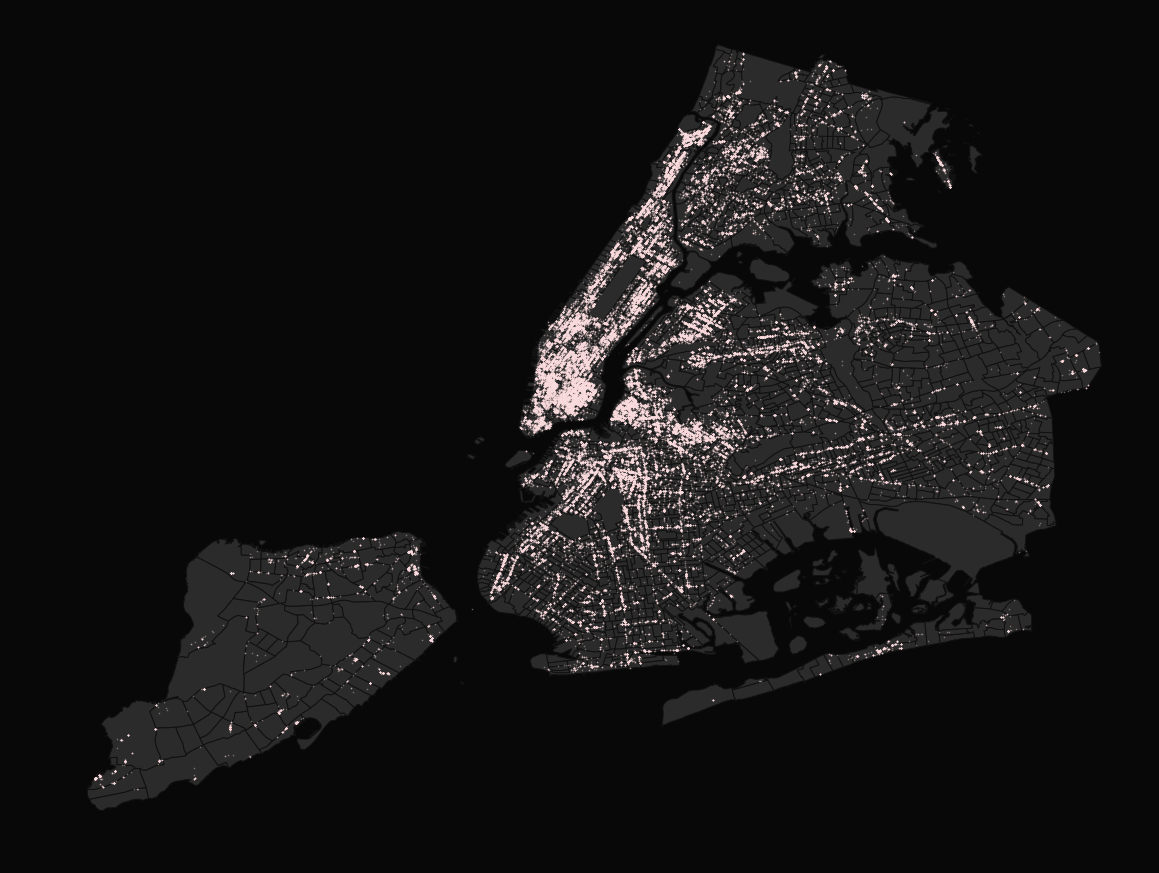

In [8]:
#create the canvas
fig, ax = plt.subplots(figsize = (20,16), facecolor = "#080808")

#plot the basemap
tracts.plot(ax = ax, color='#2b2b2b', edgecolor='#111111')

#plot the noise complaints
noise.plot(ax = ax, color='#fedfe1', markersize = 0.5, alpha = 0.3)

#turn off the axis
ax.axis('off')

#optional: save the image
# plt.savefig('noise_complaints.png', dpi = 300, facecolor = "#080808")

#display the plot
plt.show()

# Binning Data Using Spatial Joins

Visualizing coordinate points is pretty and insightful, but in order to draw clearer comparisons across different areas, we need to group these points by using `gpd.sjoin()` to perform a *spatial join* that groups noise complaints by census tract.

**NOTE:** This is **very** computationally expensive and can take an unreasonably long time as the size of your data increases. If you're feeling really ambitious and want to learn more about performing spatial joins with large datasets, you should look into [R-tree indexing](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/).

In [9]:
#create a new dataset by performing a spatial join using the noise and tracts GeoDataFrames
data = gpd.sjoin(noise, tracts, how = 'left', op = 'intersects')
data.head()

,datetime,description,location_type,address,street,lat,lon,geometry,index_right,boro_code,...,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,pop
0,1/2/2013 20:49,Loud Music/Party,Store/Commercial,225 CHAUNCEY STREET,CHAUNCEY STREET,40.680803,-73.926067,POINT (-73.92606738000001 40.68080314),1439.0,3,...,Brooklyn,E,038100,381,BK61,Crown Heights North,4006,2.578249e+06,6811.269002,4763.0
1,1/3/2013 23:46,Loud Music/Party,Club/Bar/Restaurant,64 EAST 1 STREET,EAST 1 STREET,40.723582,-73.989162,POINT (-73.98916238 40.7235816),1979.0,1,...,Manhattan,I,003602,36.02,MN22,East Village,3809,9.610705e+05,4076.249878,3151.0
2,1/3/2013 22:39,Loud Music/Party,Club/Bar/Restaurant,1233 FLATBUSH AVENUE,FLATBUSH AVENUE,40.640182,-73.955306,POINT (-73.95530567 40.64018175),250.0,3,...,Brooklyn,E,079000,790,BK95,Erasmus,4010,1.965032e+06,5950.853444,5094.0
3,1/3/2013 23:22,Loud Music/Party,Club/Bar/Restaurant,119 ST MARKS PLACE,ST MARKS PLACE,40.727267,-73.984497,POINT (-73.98449673 40.72726727),2045.0,1,...,Manhattan,I,003200,32,MN22,East Village,3809,2.335527e+06,6358.435386,8234.0
4,1/4/2013 0:53,Loud Music/Party,Club/Bar/Restaurant,673 FLATBUSH AVENUE,FLATBUSH AVENUE,40.656833,-73.960138,POINT (-73.96013845 40.65683338),252.0,3,...,Brooklyn,E,079601,796.01,BK60,Prospect Lefferts Gardens-Wingate,4011,1.188359e+06,4382.684861,4413.0


# Counting Complaints per Tract

Now that we've attached a census tract to each complaint, we can use the `value_counts()` function to count the number of complaints grouped by the `tract` column.

In [10]:
#count by tract
counts = data['tract'].value_counts()

#convert to a DataFrame and fix column names
counts = pd.DataFrame(counts).rename(columns={'tract': 'complaints'})
counts = counts.reset_index().rename(columns={'index': 'tract'})
counts.head()

,tract,complaints
0,1001800,3388
1,3030500,2572
2,2007000,2470
3,1003200,2352
4,3011900,2340


# Merge Grouped Complaints onto Census Tracts

We now have the number of complaints for each census tract, which means all we need to do is perform another left join onto the original `tracts` GeoDataFrame.

In [11]:
#create a new GeoDataFrame that merges the counts onto tracts
noiseMap = tracts.merge(counts, how = 'left', on = 'tract')

#any NaN values are zeros in this situation
noiseMap['complaints'] = noiseMap['complaints'].fillna(0)

#remove parks & census tracts without people -- these will skew our data
noiseMap = noiseMap[noiseMap.ntaname.str.contains('park-cemetery-etc-') == False]
noiseMap = noiseMap[noiseMap['pop'] > 0]

#create a new column for per-capita complaints
noiseMap['complaints_pc'] = noiseMap['complaints'] / noiseMap['pop']

noiseMap.head()

,boro_code,tract,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,pop,complaints,complaints_pc
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...,2112,0.0,0.000000
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...,7316,870.0,0.118917
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...,1992,163.0,0.081827
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...,230,16.0,0.069565
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,966,323.0,0.334369


# Plotting Late-Night Commercial Noise Complaints by Tract

Now lets plot our map of noise complaints on top of the basemap.

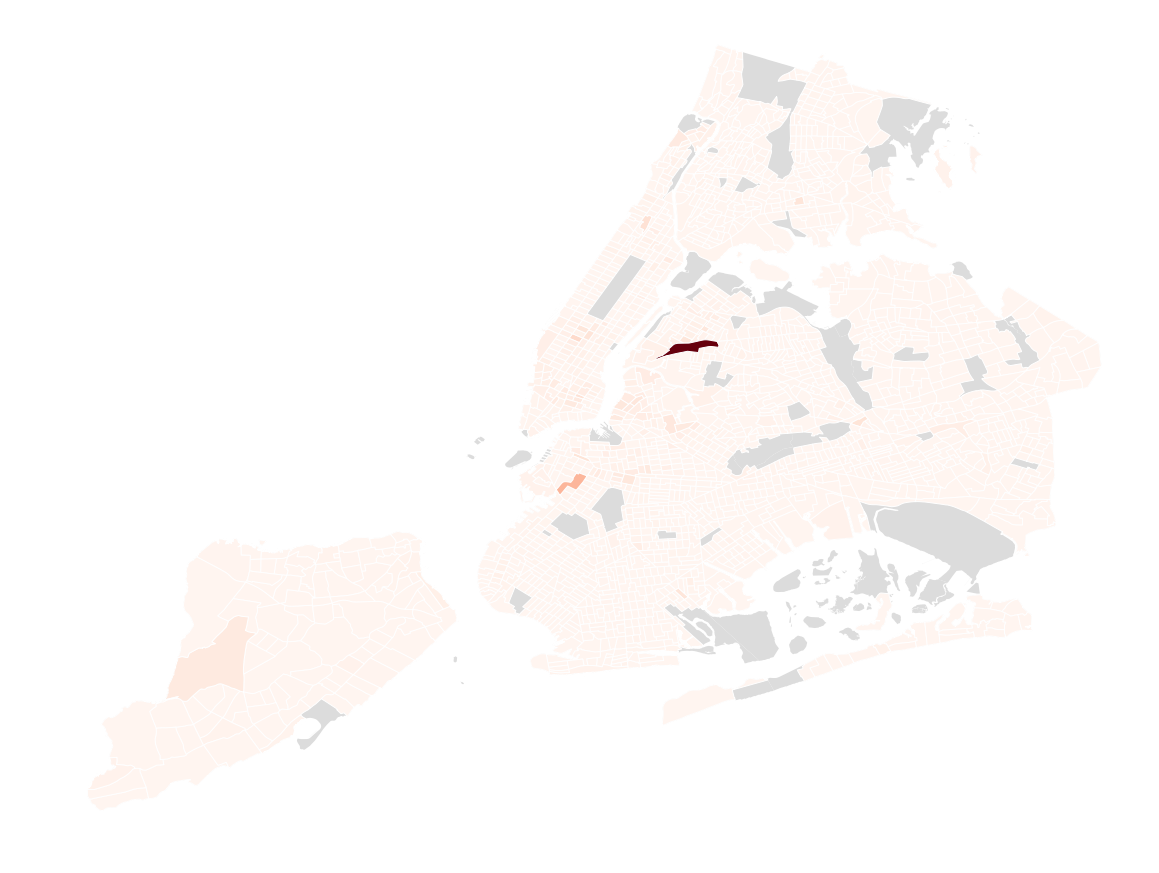

In [12]:
fig, ax = plt.subplots(figsize = (20,16))
tracts.plot(ax = ax, color = 'gainsboro')
noiseMap.plot(ax = ax, column = 'complaints_pc', cmap = 'Reds', edgecolor = 'white')
ax.axis('off')
plt.show()

Doesn't look particularly great, does it? This is because most census tracts have a similar level of per-capita noise complaints. Let's try looking at outliers instead...

# Plotting Outliers

This is about as statistics-heavy as this workshop is going to get.

We're interested in identifying areas that experience an unusually-high level of per-capita noise complaints--in other words: outliers. There are many different ways to calculate outliers, but the most common is to find values that are 2 or 3 **standard deviations** away from the **mean** (depending on whether you are using a 95% or 99% confidence interval).

**NOTE:** *If nothing written above makes any sense to you -- don't worry. This is basically a way of looking at how extreme certain data points are compared to the rest of the data.*

In [13]:
#create a variable for the mean, standard deviation, and an upper-bound to identify outliers
meanComp = noiseMap.complaints_pc.mean()
sdComp = noiseMap.complaints_pc.std()
upperBound = meanComp + 2 * sdComp

#create a new dataset that filters only those that are greater than or equal to our upper-bound
outlierMap = noiseMap[noiseMap.complaints_pc >= upperBound]
outlierMap

,boro_code,tract,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,pop,complaints,complaints_pc
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...,966,323.0,0.334369
5,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860641,"POLYGON ((-73.98411754823195 40.7548420534646,...",117,97.0,0.829060
81,3,3024900,Brooklyn,E,024900,249,BK75,Bedford,4003,1.813353e+06,5777.655193,"POLYGON ((-73.94716450741116 40.6851123909669,...",3823,1477.0,0.386346
107,3,3030500,Brooklyn,E,030500,305,BK61,Crown Heights North,4006,3.474329e+06,7369.206067,POLYGON ((-73.95529361599387 40.67920315104393...,5549,2572.0,0.463507
172,3,3051700,Brooklyn,I,051700,517,BK73,North Side-South Side,4001,2.020312e+06,6225.178515,"POLYGON ((-73.95064594267232 40.7217056932818,...",1735,826.0,0.476081
219,3,3065200,Brooklyn,I,065200,652,BK45,Georgetown-Marine Park-Bergen Beach-Mill Basin,4009,1.875210e+06,6302.374451,POLYGON ((-73.92842985426594 40.61497277981078...,1232,641.0,0.520292
327,2,2007000,Bronx,E,007000,70,BX55,Soundview-Bruckner,3709,2.207823e+06,6251.692530,POLYGON ((-73.86264225702611 40.82817014526474...,4584,2470.0,0.538831
636,4,4005500,Queens,I,005500,55,QN68,Queensbridge-Ravenswood-Long Island City,4101,1.786238e+06,5268.301308,POLYGON ((-73.92415700043728 40.75396114233173...,1067,559.0,0.523899
638,1,1012500,Manhattan,I,012500,125,MN17,Midtown-Midtown South,3807,1.875482e+06,5683.937071,POLYGON ((-73.98042606433056 40.75989908107926...,2719,1350.0,0.496506
646,1,1003001,Manhattan,E,003001,30.01,MN27,Chinatown,3809,1.344751e+06,4758.460807,POLYGON ((-73.98382387298203 40.72147287156432...,4492,1784.0,0.397150


Now that we have our outliers, we can plot them on top of our basemap using a single color.

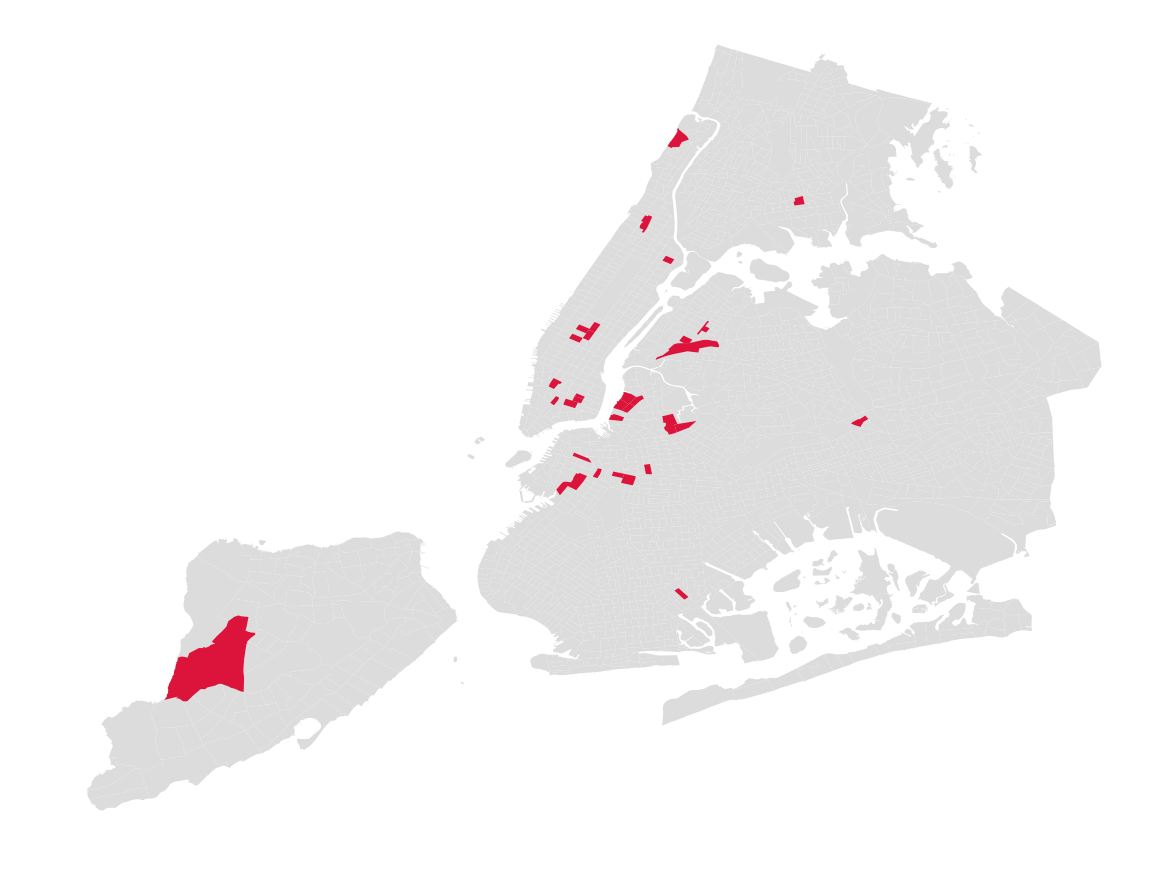

In [14]:
#set up the canvas
fig, ax = plt.subplots(figsize = (20,16))

#plot the basemap
tracts.plot(ax = ax, color = 'gainsboro')

#plot the outliers
outlierMap.plot(ax = ax, color = 'crimson')

#hide axes
ax.axis('off')

#save the figure
plt.savefig('noise_complaint_outliers.png', dpi = 300, transparent = True)

#display the figure
plt.show()

# Other Tools

Geopandas is a good tool for learning how to work with data and prepare it for visualization, but there are a number of other tools that might be better suited for your needs. If you're looking to get into interactive, web-based visualizations, then [CARTO](https://carto.com/), [Leaflet](https://leafletjs.com/), and [Mapbox](https://www.mapbox.com/) are good places to start.

If you're feeling super scientific and love Windows XP style UIs, then [ArcGIS](http://www.arcgis.com/index.html) is the gold-standard GIS software.